In [ ]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


data = [[0.002, 105, 15], [0.002, 105, 31], [0.0025, 105, 41.333333], [0.0025, 140, 50.75], [0.003, 70, 47.75], [0.003, 105, 95.5], [0.003, 140, 120.25], [0.0035, 70, 51.5], [0.0035, 105, 111], [0.0035, 140, 132.75], [0.004 , 35, 40], [0.004 , 70, 75.25], [0.004 , 105, 137.75], [0.004 , 140, 167], [0.0045 , 35, 25.5], [0.0045 , 70, 97.25], [0.0045 , 105, 159.25], [0.0045 , 140, 189.75], [0.005 , 35, 17.3333333333333], [0.005 , 70, 81.25], [0.005 , 105, 150.75], [0.005 , 140, 174.5], [0.0055 , 35, 26.5], [0.0055 , 70, 109], [0.0055 , 105, 180.5], [0.0055 , 140, 205.5], [0.006 , 35, 30], [0.006 , 70, 103.25], [0.006 , 105, 166.5], [0.006 , 140, 204], [0.0065 , 35, 53.5], [0.0065 , 70, 137], [0.0065 , 105, 210.75], [0.0065 , 140, 234.75], [0.007 , 35, 67.25], [0.007 , 70, 153], [0.007 , 105, 229.25], [0.007 , 140, 249.5], [0.0075 , 35, 69.5], [0.0075 , 70, 149.75], [0.0075 , 105, 215.25], [0.0075 , 140, 251.25], [0.008 , 35, 69.75], [0.008 , 70, 156.5], [0.008 , 105, 227], [0.008 , 140, 257.25], [0.0085 , 35, 81.5], [0.0085 , 70, 166.75], [0.0085 , 105, 258.75], [0.0085 , 140, 284.25], [0.009 , 35, 66.25], [0.009 , 70, 153.25], [0.009 , 105, 233.75], [0.009 , 140, 254.25], [0.0095 , 35, 55.5], [0.0095 , 70, 154.5], [0.0095 , 105, 240.5], [0.0095 , 140, 264.5],[0.01 , 35, 77.25], [0.01 , 70, 165], [0.01 , 105, 250], [0.01 , 140, 277.75]]

experiment_df = pd.DataFrame(data, columns=['intensity', 'exposure_time', 'cured_height'])

# 모델 함수 정의
# def model_function(x, a, b, c, d):
#     return np.log(b * x + c) / np.log(a) + d
def model_function(x, b, c, d):
    return np.log(b * x + c) + d

grouped = experiment_df.groupby('intensity')
intensity_data = grouped.apply(lambda x: (x['exposure_time'].to_numpy(), x['cured_height'].to_numpy()))


# 결과 출력
for intensity, values in intensity_data.items():
    x_data = values[0]
    y_data = values[1]

    if (len(x_data) < 4):
        continue
    print(x_data)
    # 초기 파라미터 추측
    initial_guess = [1, 1, 1]

    # 파라미터 최적화
    params, params_covariance = curve_fit(model_function, x_data, y_data, p0=initial_guess)

    # 최적화된 파라미터 출력
    print("Optimized parameters: b={}, c={}, d={}".format(params[0], params[1], params[2]))

    df_origin = pd.read_csv('./data_origin_scale.csv')
    unique_exposure_times = df_origin['exposure_time'].unique()
    x_data_to_pred = np.sort(unique_exposure_times)

    mask = np.isin(x_data_to_pred, x_data)
    close_mask = np.array([np.any(np.isclose(x, x_data)) for x in x_data_to_pred])
    combined_mask = mask | close_mask

    # 근접한 값이나 정확히 일치하는 값을 제외합니다.
    x_data_to_pred_filtered = x_data_to_pred[~combined_mask]

    # x_data_to_pred_filtered에서 예측을 수행합니다.
    y_pred_filtered = model_function(x_data_to_pred_filtered, *params)
    print(y_pred_filtered)
    # 시각화
    plt.figure(figsize=(10, 5))
    plt.scatter(x_data, y_data, color='blue', label='Test Data')
    plt.plot(x_data_to_pred_filtered, y_pred_filtered, color='red', label='Interpolation')
    plt.title('Cured Height vs. Exposure Time: Model Fit')
    plt.xlabel('Exposure Time (seconds)')
    plt.ylabel('Cured Height (units)')
    plt.legend()
    plt.show()


Optimized parameters: a=1.012247085571289 b=10.800833702087402, c=1.7920384407043457, d=0.6725229024887085


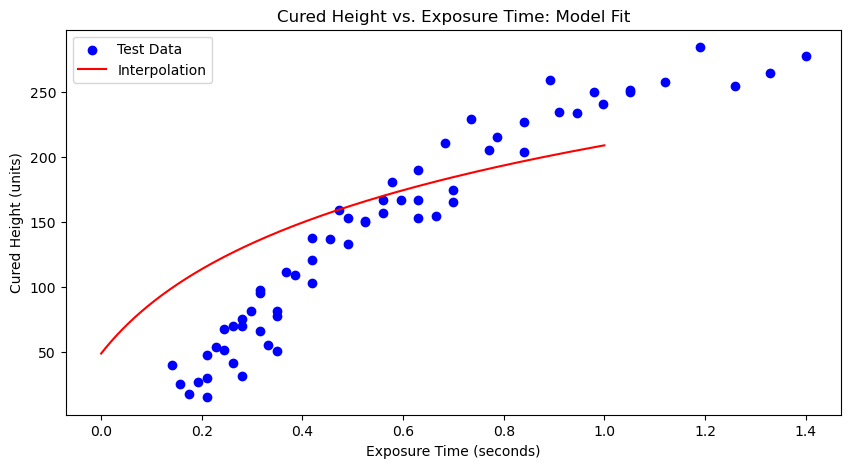

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from make_dataset import apply_scaler
from torch.utils.data import DataLoader
from scipy.optimize import curve_fit


def model(x, params):
    a, b, c, d = params[0], params[1], params[2], params[3]
    # log_a(bx + c) + d, log_a(bx + c)는 log(bx + c) / log(a)
    return torch.log(b * x + c) / torch.log(a) + d

df_scaled = pd.read_csv('./data_minmax_scale_2.csv')
unique_intensity_exposure = df_scaled['intensity_exposure'].unique()
x_data_to_pred = np.sort(unique_intensity_exposure)

experiment_scaled_df = pd.read_csv('./data_experiment_2.csv')
x = torch.tensor(experiment_scaled_df['intensity_exposure'].values, dtype=torch.float32)
y = torch.tensor(experiment_scaled_df['cured_height'].values, dtype=torch.float32)

x_data = experiment_scaled_df['intensity_exposure'].to_numpy()
y_data = experiment_scaled_df['cured_height'].to_numpy()
mask = np.isin(x_data_to_pred, x_data)
close_mask = np.array([np.any(np.isclose(x, x_data)) for x in x_data_to_pred])
combined_mask = mask | close_mask
x_data_to_pred_filtered = x_data_to_pred[~combined_mask]

params = torch.tensor([2.0, 10.0, 1.0, 0.0], requires_grad=True)

criterion = nn.MSELoss()
optimizer = optim.Adam([params], lr=0.0001)
min_loss =float('inf')
attempt = 0
while attempt < 10:
    optimizer.zero_grad()
    output = model(x, params)
    loss = criterion(output, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if loss.item() < min_loss:
        min_loss = loss.item()
        attempt = 0
    else:
        attempt += 1

print(f"Optimized parameters: a={params[0]} b={params[1]}, c={params[2]}, d={params[3]}")

x_data_to_pred_filtered_tensor = torch.tensor(x_data_to_pred_filtered)
y_pred_filtered = model(x_data_to_pred_filtered_tensor, params).detach().numpy()
plt.figure(figsize=(10, 5))
plt.scatter(x_data, y_data, color='blue', label='Test Data')
plt.plot(x_data_to_pred_filtered, y_pred_filtered, color='red', label='Interpolation')
plt.title('Cured Height vs. Exposure Time: Model Fit')
plt.xlabel('Exposure Time (seconds)')
plt.ylabel('Cured Height (units)')
plt.legend()
plt.show()

/tmp/ipykernel_1585282/1897726341.py:18: RuntimeWarning: invalid value encountered in log
  return np.log(b * x + c) / np.log(a) + d


Optimized parameters: a=1.0054734428212373, b=57.243712379217264, c=10.25605285749445, d=-529.6879932288782


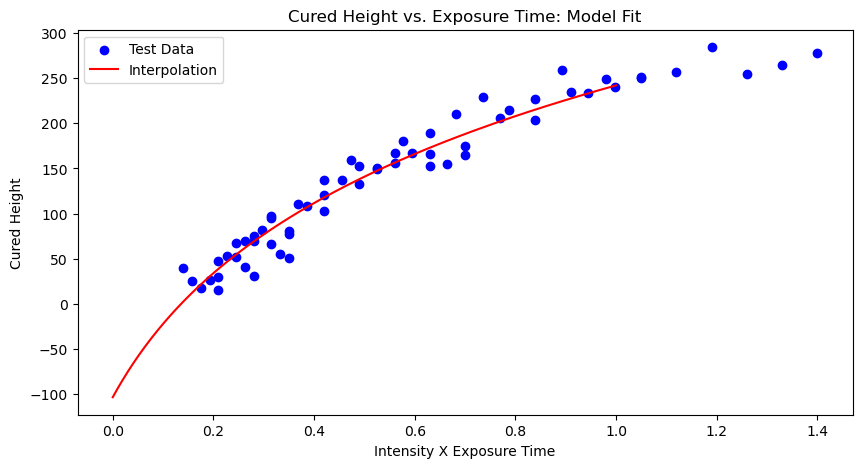

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from make_dataset import apply_scaler
from torch.utils.data import DataLoader
from scipy.optimize import curve_fit

experiment_scaled_df = pd.read_csv('./data_experiment_2.csv')
x_data = experiment_scaled_df['intensity_exposure'].to_numpy()
y_data = experiment_scaled_df['cured_height'].to_numpy()

def model_function(x, a, b, c, d):
    return np.log(b * x + c) / np.log(a) + d

# 초기 파라미터 추측
initial_guess = [2, 1, 1, 1]

# 파라미터 최적화
params, params_covariance = curve_fit(model_function, x_data, y_data, p0=initial_guess)

print("Optimized parameters: a={}, b={}, c={}, d={}".format(params[0], params[1], params[2], params[3]))

df_scaled = pd.read_csv('./data_minmax_scale_2.csv')
unique_intensity_exposure = df_scaled['intensity_exposure'].unique()
x_data_to_pred = np.sort(unique_intensity_exposure)

mask = np.isin(x_data_to_pred, x_data)
close_mask = np.array([np.any(np.isclose(x, x_data)) for x in x_data_to_pred])
combined_mask = mask | close_mask

# 근접한 값이나 정확히 일치하는 값을 제외합니다.
x_data_to_pred_filtered = x_data_to_pred[~combined_mask]

# x_data_to_pred_filtered에서 예측을 수행합니다.
y_pred_filtered = model_function(x_data_to_pred_filtered, *params)

plt.figure(figsize=(10, 5))
plt.scatter(x_data, y_data, color='blue', label='Test Data')
plt.plot(x_data_to_pred_filtered, y_pred_filtered, color='red', label='Interpolation')
plt.title('Cured Height vs. Exposure Time: Model Fit')
plt.xlabel('Intensity X Exposure Time')
plt.ylabel('Cured Height')
plt.legend()
plt.show()

In [1]:
import pandas as pd
import pickle
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('./data_origin_scale.csv')
data['intensity_exposure'] = data['intensity'] * data['exposure_time']

scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
data_scaled.to_csv('data_minmax_scale_2.csv', index=False)

print(data.head())
print(data_scaled.head())

scalers = {}
for col in data.columns:
    scaler = MinMaxScaler()
    data[col] = scaler.fit_transform(data[[col]])
    scalers[col] = scaler

with open('./scalers_2.pkl', 'wb') as f:
    pickle.dump(scalers, f)

     PI            Do  intensity  exposure_time  cured_height  \
0  7500  2.000000e-11      0.002            265             3   
1  7500  2.000000e-11      0.002            270             6   
2  7500  2.000000e-11      0.002            275             7   
3  7500  2.000000e-11      0.002            280             9   
4  7500  2.000000e-11      0.002            285            10   

   intensity_exposure  
0                0.53  
1                0.54  
2                0.55  
3                0.56  
4                0.57  
    PI        Do  intensity  exposure_time  cured_height  intensity_exposure
0  0.0  0.310345   0.111111       0.872727      0.013986            0.116279
1  0.0  0.310345   0.111111       0.890909      0.034965            0.119857
2  0.0  0.310345   0.111111       0.909091      0.041958            0.123435
3  0.0  0.310345   0.111111       0.927273      0.055944            0.127013
4  0.0  0.310345   0.111111       0.945455      0.062937            0.130590
